# Maximum Likelihood Estimators

### Christian Holm Christensen

## Setup
First, some setup code 

In [1]:
%matplotlib inline
import numpy as np
import sympy as sy
import scipy as sp
import scipy.stats 
import matplotlib.pyplot as plt 
from matplotlib import rcParams
rcParams['figure.figsize'] = [8.,8.]
rcParams['image.cmap'] = 'cividis'
rcParams['font.serif'] = ['Palatino'] + rcParams['font.serif']
rcParams['font.family'] = ['serif']
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['axes.formatter.use_mathtext'] = True
sy.init_printing()

The function below is needed to expand 

$$\log\left(\prod_{i=1}^{N}\ldots\right) \rightarrow 
\sum_{i=1}^{N} \log(\ldots)\quad,$$

for older versions ($<1.5$) of _SymPy_.   Just ignore it - in newer version this is the same as 

    expr.expand(log=True,force=True) 
    

In [2]:
def concrete_expand_log(expr, first_call=True,**kwargs):
    """Force expansion of `log(Product(...))"""
    from sympy import __version__ as syvers
    try:
        if float(syvers) >= 1.5:
            return expr.expand(log=True,force=True,**kwargs)
    except:
        pass
    
    from sympy.concrete.products import Product
    from sympy.concrete.summations import Sum
    from sympy.functions.elementary.exponential import log

    if first_call:
        expr = expr.expand(log=True,**kwargs)
    if expr.args is ():
        return expr
    if expr.func is log and expr.args[0].func is Product:
            return Sum(log(expr.args[0].args[0]), 
                       *expr.args[0].args[1:])
    return expr.func(*map(lambda x:
                          concrete_expand_log(x, False,**kwargs),
                          expr.args))

# Normal distribution 

## The problem

Given the probability density function 

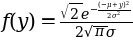

In [3]:
sigma = sy.symbols('sigma',real=True,positive=True)
mu, y = sy.symbols('mu y',real=True)
ff    = sy.Function('f',real=True,positive=True)
f     = 1/(sy.sqrt(2*sy.pi)*sigma)*sy.exp(-sy.S.Half*(y-mu)**2/sigma**2)
sy.Eq(ff(y),f)

we can define the likelihood function of the sample

$$\{x_i | i =1,\ldots,N\}\quad,$$

as

In [4]:
N  = sy.symbols('N',integer=True,positive=True)
i  = sy.Idx('i',(sy.S.One,N))
x  = sy.Indexed('x',i)
L  = sy.Product(f.subs(y,x),i)
fL = sy.Function('L')
sy.Eq(fL(x,mu,sigma),L)

We can define the _maximum likelihood estimators_ (MLEs) of $\mu$ and $\sigma$ by maximizing $L$ with respect to those variables.  To make it easier to work with, we maximize the logarithm of $L$ 

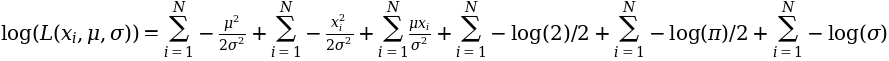

In [5]:
LLH = concrete_expand_log(sy.log(L))\
    .expand(log=True,force=True)
sy.Eq(sy.log(fL(x,mu,sigma)),LLH)

which we can differentiate with respect to $\mu$ (and $\sigma$)

In [6]:
dLLHmu = LLH.diff(mu).doit().simplify()
sy.Eq(sy.Derivative(sy.log(fL(x,mu,sigma)),mu),dLLHmu)

In [7]:
dLLHsig = LLH.diff(sigma).doit().simplify()
sy.Eq(sy.Derivative(sy.log(fL(x,mu,sigma)),sigma),dLLHsig)

We now want to solve 

\begin{align*}
  \frac{\partial \log L(x,\mu,\sigma)}{\partial \mu} &= 0\\
  \frac{\partial \log L(x,\mu,\sigma)}{\partial \sigma} &= 0\quad,
\end{align*} 

to find the _maximum likelihood estimators_ $\hat{\mu}$ and $\hat{\sigma}$.  First, we solve for $\mu$ 

In [8]:
emu = sy.solve(dLLHmu,mu)[0]
sy.Eq(sy.symbols('muhat'),emu)

and similarly for $\hat\sigma$ (note, there are two solutions - a positive and a negative one - we opt for the positive one)

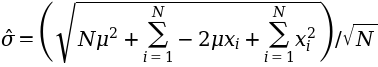

In [9]:
esigma = sy.solve(dLLHsig,sigma)[1]
sy.Eq(sy.symbols('sigmahat'),esigma)

which, albeit a little tangled, we recognise as 

$$\hat{\sigma} = \frac{1}{\sqrt{N}}\sqrt{\sum_{i=1}^N(x_i-\mu)^2}\quad.$$ 

Let us test that this is indeed the case 

In [10]:
esigma2 = 1/N * sy.Sum((x-mu)**2,i)
sy.Eq(esigma**2,esigma2.expand()).doit()

Thus, we find the familiar result that the maximum likelihood estimator of $\mu$ is the _sample mean_ 

$$\hat\mu = \overline{x} = \frac{1}{N}\sum_{i=1}^N x_i\quad,$$ 

and the maximum likelihood estimator of $\sigma$ is the square root of the _sample variance_ around $\mu$ 

$$\hat\sigma = \sqrt{s^2}_\mu = \frac{1}{\sqrt{N}}\sqrt{\sum_{i=1}^N (x_i-\mu)^2}\quad.$$ 

If we replace $\mu\rightarrow\hat\mu=\overline{x}$, then we introduce a _bias_, and we must use multiply by Bessel's correction $N/(N-1)$, and we get 

$$s^2 = \frac{1}{N-1}\sum_{i=1}^N (x-\overline{x})^2\quad.$$

## Numerical approach

In the following we will develop a numerical approach to the problem. We start out with a sample $\{x_i|i=1,\ldots,50\}$ drawn from a normal distribution with $\mu=0.2$ and $\sigma=0.1$. 

In [11]:
np.random.seed(123456)
tmu    = 0.2
tsigma = 0.1
n      = 50
data   = np.random.normal(tmu,tsigma,n)

Next, we want to evaluate $\log L(x,\mu,\sigma)$ over our sample and both the input parameters as well as estimates of these.  We can do this by `lambdify` our variable `LLH` above, or we can write it ourselves.   Since we started our index in the calculations above at $1$ (as is customary in Mathematics), we must wrap the `lambdify`d function.  

In [12]:
nllhs = sy.lambdify((x.base,mu,sigma,N),LLH)
def nllhw(x,mu,sigma):
    tmp = np.hstack((data[0],data))
    return nllhs(tmp,mu,sigma,len(x))

However, we can also code this up directly using _NumPy_

In [13]:
def nllhn(x,mu,sigma,axis=0):
    return np.log(sp.stats.norm.pdf(x,mu,sigma)).sum(axis=axis)

Let us run both functions and compare the results 

In [14]:
rs = nllhw(data,tmu,tsigma)
rn = nllhn(data,tmu,tsigma)
print(rs,rn)

47.32902961551521 47.329029615515154


which agree expect on the very last two digits (we can live with that).  Let us see which implementation performs best 

In [15]:
%timeit nllhw(data,tmu,tsigma)

1000 loops, best of 5: 1.26 ms per loop


In [16]:
%timeit nllhn(data,tmu,tsigma)

The slowest run took 6.57 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 60.8 µs per loop


It looks like we should stick with the direct implementation (`nllhn`), so we define an alias for that 

In [17]:
nllh = nllhn

### Likelihood of _true_ parameters 

Above we evaluated 

$$\left.\log L(x,\mu,\sigma)\right|_{\mu=\mu,\sigma=\sigma}=42.38\quad,$$

for the _true_ parameter values.  We want to compare to this value later, so we store the result 

In [18]:
tllh = nllh(data,tmu,tsigma)
print(tllh)

47.329029615515154


### Likelihood of estimators 

We deduced above that the estimators of $\mu$ and $\sigma$ are the sample mean and standard deviation.  We can evaluate the likelihood of these directly 

In [19]:
ellh = nllh(data,data.mean(),data.std(ddof=1))
print(ellh)

49.915544684462695


We see that 

$$ L(x,\mu,\sigma) < L(x,\overline{x},s_x) = L(x,\hat\mu,\hat\sigma)\quad,$$ 

as expected. 

### Raster scan as estimators 

Suppose it is hard (if not impossible) to calculate the parameter estimators.  Then, a brute force approach to estimating the parameters is a so-called _raster scan_.  

The idea is pretty simple - vary each parameter within some reasonable limits and calculate the (log-)likelihood at each point in the parameter space.  The estimates of the parameters is then where the likelihood is the largest.  

We will apply this method to the problem above.  First, we set up ranges for our parameters $\mu$ and $\sigma$ as 

$$[0,0.5]\quad[10^{-2},10^{0}]\quad,$$

respectively, both in 100 steps.  Note, the $\sigma$ points are logarithmically uniform in the range. 

In [20]:
rmu    = np.linspace(0,0.5,30)
rsigma = np.logspace(-2,0,30)

We want to evaluate $\log L$ over all combinations of these ranges.  To do that, we create a so-called _mesh grid_.  That is, we make two matrices $\mathrm{M}$ and $\Sigma$ where the $\mu$ range is repeated in $\mathrm{M}$ in every row, and the $\sigma$ range is repeated in every column of $\Sigma$.  With these two matrices, we can evaluate $\log L$ at every combination of $\mu$ and $\sigma$ given the data. 

In [21]:
mmu, msigma = np.meshgrid(rmu,rsigma)

Let us calculate the log-likelihood at every point in our grid. However, we need to do a little trick first.  Above, in our function `nllhn`, we pass in 3 arguments $x,\mu,\sigma$.  If these are arrays, then they must be compatible for the calculation to make sense.  The rules enforced by _NumPy_ are roughly

- Arrays must have the same number of dimensions.  In our case, `data` has 1 dimension of size 50. Our grid points have 2 dimensions of size 100 each. 
- If, in $a\,\mathrm{op}\,b$ both $a$ and $b$ have exactly the same number of dimensions and these are of equal length, we perform the operation $\mathrm{op}$ element by element.  
- If, however, $a$ and $b$ have the same number of dimensions but in either $a$ or $b$ one dimension has size 1 it implies that we should perform $\mathrm{op}$ with combining all other dimensions with the dimension in question.   Thus, if 

  $$a = \begin{bmatrix}\begin{bmatrix}
  a_1\\a_2\end{bmatrix}\end{bmatrix}\quad,$$ 

  (i.e., 2 dimensions, first which is 1) and 

  $$b = \begin{bmatrix} b_{11} & b_{12}\\
  b_{21} & b_{22}\end{bmatrix}\quad,$$ 
  
  (i.e., 2 dimensions, both of length 2) then 

  $$a\,\mathrm{op}\,b = \begin{bmatrix} 
    a_1\,\mathrm{op}\,b_{11} & a_1\,\mathrm{op}\,b_{12}\\ 
    a_2\,\mathrm{op}\,b_{21} & a_2\,\mathrm{op}\,b_{22}\\ 
    \end{bmatrix}\quad,$$
    
  that is $a$ is _broadcast_ over $b$.  
  
This is what we want in our situation. To make this work, we define three-dimensional arrays of our data and grid points 

In [22]:
data3   = data[:,np.newaxis,np.newaxis]
mmu3    = mmu[np.newaxis,:,:]
msigma3 = msigma[np.newaxis,:,:]

In this way, $\mu$ and $\sigma$ will be combined at every point in the grid when calculating 

$$\frac{(\cdot + \mu)^2}{\sigma^2}\quad,$$

and the data will be broadcast over all points when we do 

$$\frac{(x + \cdot)^2}{\cdot}\quad.$$  

Finally, we sum over the first axis to produce a single matrix with our log-likelihood evaluated there. 

In [23]:
gllh = nllh(data3,mmu3,msigma3)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Let us plot the found likelihoods 

In [24]:
plt.contourf(mmu,msigma,gllh,20)
plt.yscale('log')
plt.colorbar(label=r'$\log L$')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$');

We will search for the maximum value in this map.  Note, `argmax` from _NumPy_ will give a _flat_ ("raveled") index, but we can use `numpy.unravel_index` to get back the two-dimensional index.  

In [25]:
maxij = np.unravel_index(gllh.argmax(),gllh.shape)

Let us find the corresponding $\mu$ and $\sigma$ values. Note, the first coordinate returned is the row number - i.e., $\sigma$ index, and the second is the column number - i.e., the $\mu$ index.  We find 

In [26]:
sllh   = gllh[maxij]
smu    = rmu[maxij[1]]
ssigma = rsigma[maxij[0]]
print(f'Log-likelihood at mu={smu:.3f},sigma={ssigma:.3f} '
      f'is {sllh:.2f}')

Log-likelihood at mu=0.172,sigma=0.092 is 49.86


Let us plot these various numbers onto our likelihood-map 

In [27]:
plt.pcolor(mmu,msigma,gllh,vmin=0)
plt.plot(tmu,tsigma,'or',label=r'Input: $\log L={:.2f}$'.format(tllh))
plt.plot(data.mean(),data.std(ddof=1),'sg',
         label=r'Estimator: $\log L={:.2f}$'.format(ellh))
plt.plot(smu,ssigma,'*b',
         label=r'Raster: $\log L={:.2f}$'.format(sllh))
plt.yscale('log')
plt.colorbar(label=r'$\log L$')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.legend(bbox_to_anchor=(1.2,1),loc='upper left');

## Run the test several times

We want to run the above raster search for different data sets, so we code up a function to do the whole shebang for us 

In [28]:
def raster(data,mugrid,sigmagrid):
    data3 = data[:,np.newaxis,np.newaxis]
    gllh  = nllh(data3,mugrid,sigmagrid)
    i,j   = np.unravel_index(gllh.argmax(),gllh.shape)
    return mugrid[0,i,j],sigmagrid[0,i,j],gllh[i,j] 

We test this on the data we already have 

In [29]:
assert raster(data,mmu3,msigma3) == (smu,ssigma,sllh)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


For each data set, we want to calculate not only the raster estimate, but also the likelihood of from our known estimators $\hat\mu=\overline{x}$ and $\hat\sigma=s_x$ and from the input values.  Thus, we create another function that evaluates all 3 likelihoods and return those, for a given data set 

In [30]:
def allllh(data,mu,sigma,mugrid,sigmagrid):
    tllh    = nllh(data,mu,sigma)
    ellh    = nllh(data,data.mean(),data.std(ddof=1))
    *_,rllh = raster(data,mugrid,sigmagrid)
    return tllh, ellh, rllh 

Just to make things a little nicer, we formulate a function that performs $n$ of these evaluations and returns an array with the results for each iteration. 

In [31]:
def test(n,mu=tmu,sigma=tsigma,lmu=(0,0.5),lsigma=(0.01,1),ngrid=30):
    rmu         = np.linspace(*lmu,ngrid)
    rsigma      = np.geomspace(*lsigma,ngrid)
    mmu, msigma = np.meshgrid(rmu,rsigma)
    mmu3        = mmu[np.newaxis,:,:]
    msigma3     = msigma[np.newaxis,:,:]
    
    ret = []
    for _ in range(n):
        data = np.random.normal(mu,sigma,50)
        one  = allllh(data,mu,sigma,mmu3,msigma3)
        ret.append(one)
        
    return np.array(ret)

We will run this test 100 times and plot the result

In [32]:
t3 = test(100)
plt.plot(t3[:,0],t3[:,1],'o',label='Estimator')
plt.plot(t3[:,0],t3[:,2],'s',markerfacecolor='none',label='Raster')
plt.xlabel(r'$\log L(x,\mu,\sigma)$')
plt.ylabel(r'Maximised $\log L$')
plt.plot([t3[:,0].min(),t3[:,0].max()],
         [t3[:,0].min(),t3[:,0].max()],':k')
plt.legend()
plt.gca().set_aspect(1)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


# Another distribution 

## The problem 

### The probability density function and sampling 

We have the function 

$$f(x;\alpha,\beta) = 1 + \alpha x + \beta x^2\quad x\in[-1,1]\quad,$$

which we want to sample.  However, this function is not normalised off-hand, so we evaluate the integral over the domain 

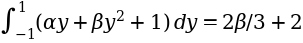

In [33]:
alpha, beta = sy.symbols('alpha beta',real=True)
f = 1 + alpha * y + beta * y**2 
sy.Eq(sy.Integral(f,(y,-1,1)),f.integrate((y,-1,1)))

and thus to have a properly normalised probability density function (PDF), we define 

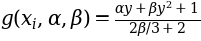

In [34]:
g = f / f.integrate((y,-1,1))
fg = sy.Function('g')
sy.Eq(fg(x,alpha,beta),g)

To sample this PDF, we want to find the cumulative density function (CDF)

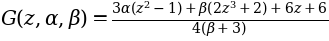

In [35]:
z = sy.symbols('z',real=True)
G = g.integrate((y,-1,z)).simplify().collect(beta)
fG = sy.Function('G')
sy.Eq(fG(z,alpha,beta),G)

We solve 

$$ G(z;\alpha,\beta) - y = 0\quad,$$ 

to find the inverse $G^{-1}$ CDF.  This function can be used to sample the PDF by sampling a uniform distribution $r\sim U[0,1)$ and evaluating $G^{-1}(r;\alpha,\beta)$

In [36]:
s = sy.solve(y-G,z)
Gm1 = s[0].simplify()

Let us plot these three functions for $\alpha=0.5$, $\beta=0.5$. 

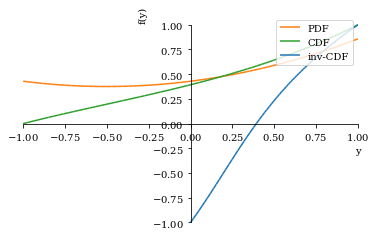

In [37]:
values = {alpha:.5,beta:.5,z:y}
p = sy.plot(g.subs(values), G.subs(values), (y,-1,1),show=False)
p.append(sy.plot(Gm1.subs(values),(y,0,1),show=False)[0])
p[0].label='PDF'
p[1].label='CDF'
p[2].label='inv-CDF'
p[0].line_color = 'C1'
p[1].line_color = 'C2'
p.legend = True
p.show()

We will use `lambdify` to convert our expression to numerical functions that we may evaluate 

In [38]:
pdf = sy.lambdify((y,alpha,beta),g)
invcdf = sy.lambdify((y,alpha,beta),Gm1)

Let us sample the PDF via our inverse CDF, histogram the results and draw the PDF on top. 

In [39]:
talpha = .6
tbeta = .5
xrng = np.linspace(-1,1,100)
data = invcdf(np.random.uniform(size=2000),talpha,tbeta)
dist = pdf(xrng,talpha,tbeta)
plt.hist(data,density=True,label='Sample')
plt.plot(xrng, dist,label='PDF')
plt.legend();

We see that our inverse CDF indeed does the trick. 

### Maximum likelihood estimates 

Next, we want to do a maximum likelihood estimate of the parameters, as we did above.  The maximum likelihood function is given by 

In [40]:
L = sy.Product(g.subs(y,x).simplify(),i)
sy.Eq(fL(x,alpha,beta),L)

and the logarithm of that yields 

In [41]:
LLH = concrete_expand_log(sy.log(L))\
    .expand(log=True,force=True)
sy.Eq(sy.log(fL(x,mu,sigma)),LLH)

The derivatives of this with respect to $\alpha,\beta$ are 

In [42]:
dLLHalpha = LLH.diff(alpha).collect(x).factor()
sy.Eq(sy.Derivative(sy.log(fL(x,alpha,beta)),alpha),dLLHalpha)

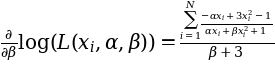

In [43]:
dLLHbeta = LLH.diff(beta).factor().simplify()
sy.Eq(sy.Derivative(sy.log(fL(x,alpha,beta)),beta),dLLHbeta)

Unfortunately, there are no solutions for these

In [44]:
sy.solve(dLLHalpha,alpha),sy.solve(dLLHbeta,beta)

so we are "stuck" trying to solve the problem numerically. 

## Numerical evaluation

We define a function to numerically evaluate the log-likehood given the data and values of $\alpha,\beta$.  We will use our `lambdify`d PDF from above to do so. 

In [45]:
def nllh(data,f,*args):
    return np.log(f(data,*args)).sum(axis=0)

Next step is to maximize this function using some library functionality.  Since the log-likelihood is monotonically increasing, we can just as well _minimise_ $-\log L$. 

Here, we will use _SciPy_'s minimization routines. To do that, we must wrap our `nllh` function together with the data and PDF to use.  

In [46]:
def wllh(args,data=data,pdf=pdf):
    return -nllh(data,pdf,*args)

We minimize this function with an initial guess of $\alpha=0,\beta=0$.  We choose to use the method _BFGS_ since that will also return the covariance matrix $C$ (actually, the inverse Hessian $H$ but $C=H^{-1}$) thus allowing us to estimate the uncertainties as 

\begin{align*}
  \delta_{\alpha} &= \sqrt{C_{0,0}}\\
  \delta_{\beta}  &= \sqrt{C_{1,1}}
\end{align*}

In [47]:
opt = sp.optimize.minimize(wllh,(0,0),method='BFGS')
nam = ['alpha','beta']
if opt.success:
    p   = opt.x 
    e   = np.sqrt(opt.hess_inv.diagonal()) 

    for pp,ee,nn in zip(p,e,nam):
        print(f'{nn:8s} = {pp:.3f} +/- {ee:.3f}')
else:
    print('Minimization failed: ',opt.message)

alpha    = 0.625 +/- 0.050
beta     = 0.398 +/- 0.092


The maximum likelihood is then 

In [48]:
mllh = -wllh(p)
print(f'Maximum log-likelihood={mllh:.2f}')

Maximum log-likelihood=-1278.42


In [49]:
# To use minuit optimizer, do 
try:
    import iminuit
    minuit = iminuit.Minuit(lambda a,b: wllh((a,b)),
                            pedantic=False)
    mopt = minuit.migrad()
    for q in mopt.params:
        print(f'{q.name:8s} = {q.value:.3f} +/- {q.error:.3f}')
except Exception as e:
    print('Failed Minuit minization: ',e)
    pass

a        = 0.625 +/- 0.071
b        = 0.398 +/- 0.133


# Log-likelihood landscape

Finally, we will make a plot of the the log-likelihood $\log L$ over the parameter space.  This is similar to what we did above in the [Raster scan](#Raster-scan-as-estimators) above. 

First, we define the ranges we're interested in.  Since we have estimates of the uncertainties on $\alpha,\beta$, we can use those to to define our ranges.  We take 4 times the uncertainty in either direction 

In [50]:
ne = 4
rngs = [np.linspace(pp-ne*ee,pp+ne*ee,100) for pp, ee in zip(p,e)]

Next, as above, we want to define a _mesh grid_, adjust matrices for extra dimensions to enable calculation over the entire grid 

In [51]:
malpha, mbeta = np.meshgrid(*rngs)
data3   = data[:,np.newaxis,np.newaxis]
malpha3 = malpha[np.newaxis,:,:]
mbeta3  = mbeta[np.newaxis,:,:]

We evaluate the log-likelihood over the grid 

In [52]:
gllh = -wllh((malpha3,mbeta3),data3)

We want to draw contours corresponding to roughly $n\sigma$ for $n=1,2,3$.  For the log-likelihood this corresponds to changes of

$$\frac{1}{2}n^2\quad,$$ 

so we set-up these levels to draw with contours. 

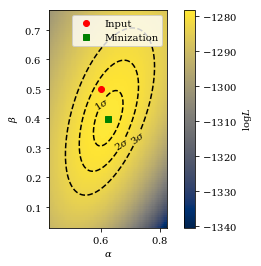

In [53]:
nsig = (3,2,1) 
lvls = mllh-np.array([1/2*n**2 for n in nsig])

bg = plt.pcolor(malpha,mbeta,gllh)
cs = plt.contour(malpha,mbeta,gllh,lvls,colors='k')
plt.clabel(cs,colors='k',
           fmt={l:r'${}\sigma$'.format(ns) 
                   for l, ns in zip(lvls,nsig)})

plt.plot(talpha,tbeta,'or',label='Input')
plt.plot(*p,'sg',label='Minization')

plt.colorbar(bg,label=r'$\log L$')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')

plt.legend()
plt.gca().set_aspect(1)